# Load data

In [189]:
import numpy as np
import pandas as pd
import os
import gzip
import matplotlib.pyplot as plt
import sys
import pickle


In [190]:
!tree

.
├── Data
│   ├── Test_Data.gz
│   ├── Test_Labels.gz
│   ├── Train_Data.gz
│   └── Train_Labels.gz
├── Fashion-GAN.ipynb
└── models
    ├── discriminator.json
    ├── discriminator_CGAN.json
    ├── discriminator_CGAN_model.h5
    ├── discriminator_model.h5
    ├── generator.json
    ├── generator_CGAN.json
    ├── generator_CGAN_model.h5
    └── generator_model.h5

2 directories, 13 files


In [191]:
def load_data():
    labels_path = "data/Train_Labels.gz"
    images_path = "data/Train_Data.gz"
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 28,28)
    return images, labels

In [192]:
images , labels = load_data()

In [193]:
print("Images shape: ",images.shape)
print("Labels shape: ",labels.shape)

Images shape:  (60000, 28, 28)
Labels shape:  (60000,)


In [194]:
class_map = {0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker",8:"Bag",9:"Ankle boot"}

# Model

In [195]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding, multiply
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization


# Using Dense layers

In [196]:


def build_generator(latent_dim, img_shape):

        model = Sequential()

        model.add(Dense(256, input_dim=latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(img_shape), activation='tanh'))
        model.add(Reshape(img_shape))

        model.summary()

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

In [197]:
def build_discriminator(img_shape):

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

# Using Conditional GAN with CNN Discriminator

In [198]:
def build_generator_CGAN(latent_dim, img_shape, num_classes):

        model = Sequential()

        model.add(Dense(256, input_dim=latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(img_shape), activation='tanh'))
        model.add(Reshape(img_shape))

        model.summary()

        noise = Input(shape=(latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)
        
        return Model([noise,label], img)

In [199]:
def build_discriminator_CGAN(img_shape, num_classes):
    
    '''
    model = Sequential()
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same',input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (4,4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    '''
    
    model = Sequential()
    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
        
    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])
    validity = model(model_input)
    
    

    return Model([img,label], validity)

In [200]:
def sample_images(epoch, latent_dim, generator, GAN = "GAN"):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    
    if GAN == 'CGAN':
        sampled_labels = np.arange(0, 10).reshape(-1, 1)
        gen_imgs = generator.predict([noise, sampled_labels])
    else:
        gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #fig.savefig("images/%d.png" % epoch)
    plt.show()
    plt.close()

In [201]:
def train(epochs, latent_dim, generator, discriminator, combined, batch_size=128, sample_interval=50, GAN = "GAN"):

    # Load the dataset
    X_train , y_train = load_data()
    
    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)


    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        if GAN == 'CGAN':
            gen_imgs = generator.predict([noise, labels])
            # Train the discriminator
            d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        else:
            gen_imgs = generator.predict(noise)
            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

        # Train the generator (to have the discriminator label samples as valid)
        if GAN == 'CGAN':
            g_loss = combined.train_on_batch([noise, sampled_labels], valid)
        else:
            g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        if epoch % 100 == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch, latent_dim=latent_dim, generator=generator, GAN = GAN)

In [202]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
num_classes = 10
optimizer = Adam(0.0002, 0.5)

In [203]:
discriminator = build_discriminator(img_shape=img_shape)
discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_36 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_83 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [204]:
generator = build_generator(latent_dim=latent_dim,img_shape=img_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_84 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
dense_78 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_85 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
dense_79 (Dense)             (None, 1024)              525312    
__________

In [205]:
discriminator_CGAN = build_discriminator_CGAN(img_shape=img_shape, num_classes=num_classes)
discriminator_CGAN.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 513       
Total params: 665,089
Trainable params: 665,089
Non-trainable params: 0
_________________________________________________________________


In [206]:
generator_CGAN = build_generator_CGAN(latent_dim=latent_dim,img_shape=img_shape,num_classes=num_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
dense_85 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 512)               2048      
_________________________________________________________________
dense_86 (Dense)             (None, 1024)              525312    
__________

# Training Vanilla GAN

In [207]:
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.885070, acc.: 44.14%] [G loss: 0.992969]


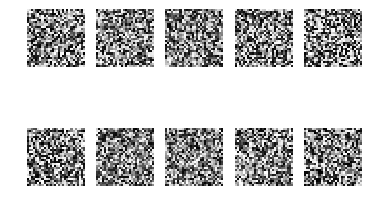

100 [D loss: 0.257946, acc.: 87.50%] [G loss: 3.306653]
200 [D loss: 0.662146, acc.: 62.89%] [G loss: 1.656946]
300 [D loss: 0.700941, acc.: 50.78%] [G loss: 0.773320]
400 [D loss: 0.632971, acc.: 57.03%] [G loss: 0.823200]
500 [D loss: 0.646763, acc.: 59.77%] [G loss: 0.839649]
600 [D loss: 0.627638, acc.: 58.59%] [G loss: 0.842130]
700 [D loss: 0.556594, acc.: 76.17%] [G loss: 0.945185]
800 [D loss: 0.624098, acc.: 64.45%] [G loss: 0.886827]
900 [D loss: 0.616342, acc.: 69.14%] [G loss: 0.898308]
1000 [D loss: 0.635336, acc.: 62.11%] [G loss: 0.847603]
1100 [D loss: 0.635158, acc.: 60.55%] [G loss: 0.861692]
1200 [D loss: 0.656805, acc.: 61.72%] [G loss: 0.869031]
1300 [D loss: 0.653002, acc.: 58.98%] [G loss: 0.835720]
1400 [D loss: 0.652394, acc.: 61.33%] [G loss: 0.831785]
1500 [D loss: 0.633019, acc.: 66.41%] [G loss: 0.852060]
1600 [D loss: 0.608892, acc.: 68.36%] [G loss: 0.889780]
1700 [D loss: 0.637778, acc.: 66.02%] [G loss: 0.857316]
1800 [D loss: 0.646141, acc.: 60.16%] [G

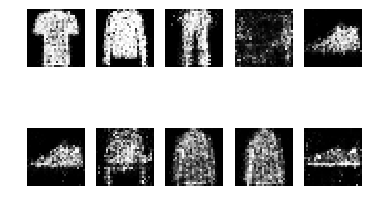

5100 [D loss: 0.649678, acc.: 62.50%] [G loss: 0.853985]
5200 [D loss: 0.660063, acc.: 64.06%] [G loss: 0.843727]
5300 [D loss: 0.673717, acc.: 57.81%] [G loss: 0.850854]
5400 [D loss: 0.677102, acc.: 58.98%] [G loss: 0.899442]
5500 [D loss: 0.643108, acc.: 64.84%] [G loss: 0.874214]
5600 [D loss: 0.667445, acc.: 58.20%] [G loss: 0.870232]
5700 [D loss: 0.661091, acc.: 56.25%] [G loss: 0.836879]
5800 [D loss: 0.660908, acc.: 55.47%] [G loss: 0.841976]
5900 [D loss: 0.654655, acc.: 62.50%] [G loss: 0.851029]
6000 [D loss: 0.683044, acc.: 54.30%] [G loss: 0.867261]
6100 [D loss: 0.646188, acc.: 67.97%] [G loss: 0.864606]
6200 [D loss: 0.653607, acc.: 62.11%] [G loss: 0.854355]
6300 [D loss: 0.648979, acc.: 62.11%] [G loss: 0.843678]
6400 [D loss: 0.669015, acc.: 58.20%] [G loss: 0.853921]
6500 [D loss: 0.685615, acc.: 55.86%] [G loss: 0.842486]
6600 [D loss: 0.652860, acc.: 60.55%] [G loss: 0.871296]
6700 [D loss: 0.663289, acc.: 58.98%] [G loss: 0.860367]
6800 [D loss: 0.678033, acc.: 5

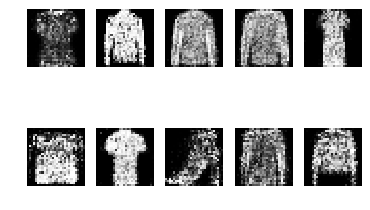

10100 [D loss: 0.690133, acc.: 58.20%] [G loss: 0.902528]
10200 [D loss: 0.679488, acc.: 58.59%] [G loss: 0.858438]
10300 [D loss: 0.670541, acc.: 61.72%] [G loss: 0.815924]
10400 [D loss: 0.667279, acc.: 55.86%] [G loss: 0.861507]
10500 [D loss: 0.673246, acc.: 57.03%] [G loss: 0.883247]
10600 [D loss: 0.694903, acc.: 55.47%] [G loss: 0.846193]
10700 [D loss: 0.673005, acc.: 61.33%] [G loss: 0.897303]
10800 [D loss: 0.650606, acc.: 62.50%] [G loss: 0.873213]
10900 [D loss: 0.696251, acc.: 54.69%] [G loss: 0.848719]
11000 [D loss: 0.675887, acc.: 57.42%] [G loss: 0.862011]
11100 [D loss: 0.676089, acc.: 60.16%] [G loss: 0.894571]
11200 [D loss: 0.641034, acc.: 62.11%] [G loss: 0.910735]
11300 [D loss: 0.686065, acc.: 52.73%] [G loss: 0.831240]
11400 [D loss: 0.673018, acc.: 57.03%] [G loss: 0.869481]
11500 [D loss: 0.647419, acc.: 63.28%] [G loss: 0.917012]
11600 [D loss: 0.656815, acc.: 62.50%] [G loss: 0.935428]
11700 [D loss: 0.682505, acc.: 55.47%] [G loss: 0.860433]
11800 [D loss:

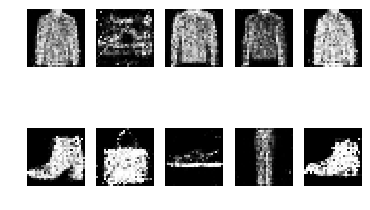

15100 [D loss: 0.658440, acc.: 59.77%] [G loss: 0.870683]
15200 [D loss: 0.661385, acc.: 59.77%] [G loss: 0.911122]
15300 [D loss: 0.665824, acc.: 61.72%] [G loss: 0.886964]
15400 [D loss: 0.670745, acc.: 58.98%] [G loss: 0.883610]
15500 [D loss: 0.639206, acc.: 64.06%] [G loss: 0.899895]
15600 [D loss: 0.669443, acc.: 55.86%] [G loss: 0.896447]
15700 [D loss: 0.686705, acc.: 56.64%] [G loss: 0.868631]
15800 [D loss: 0.664573, acc.: 62.89%] [G loss: 0.877969]
15900 [D loss: 0.666558, acc.: 61.72%] [G loss: 0.905756]
16000 [D loss: 0.649383, acc.: 60.94%] [G loss: 0.858093]
16100 [D loss: 0.647743, acc.: 63.28%] [G loss: 0.893052]
16200 [D loss: 0.623105, acc.: 68.75%] [G loss: 0.912616]
16300 [D loss: 0.669889, acc.: 54.69%] [G loss: 0.874851]
16400 [D loss: 0.632693, acc.: 66.80%] [G loss: 0.907509]
16500 [D loss: 0.653741, acc.: 63.28%] [G loss: 0.914355]
16600 [D loss: 0.682238, acc.: 50.78%] [G loss: 0.869907]
16700 [D loss: 0.632075, acc.: 63.67%] [G loss: 0.861504]
16800 [D loss:

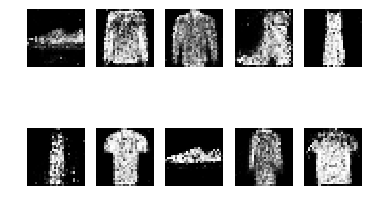

20100 [D loss: 0.660316, acc.: 64.84%] [G loss: 0.899797]
20200 [D loss: 0.644824, acc.: 62.11%] [G loss: 0.924103]
20300 [D loss: 0.652306, acc.: 60.94%] [G loss: 0.916202]
20400 [D loss: 0.642463, acc.: 66.02%] [G loss: 0.951184]
20500 [D loss: 0.655762, acc.: 60.94%] [G loss: 0.903725]
20600 [D loss: 0.627377, acc.: 64.84%] [G loss: 0.922031]
20700 [D loss: 0.635860, acc.: 66.80%] [G loss: 0.955600]
20800 [D loss: 0.639468, acc.: 64.45%] [G loss: 0.941857]
20900 [D loss: 0.635809, acc.: 66.02%] [G loss: 0.911075]
21000 [D loss: 0.682858, acc.: 54.69%] [G loss: 0.937178]
21100 [D loss: 0.642892, acc.: 65.62%] [G loss: 0.937909]
21200 [D loss: 0.647225, acc.: 63.28%] [G loss: 0.933661]
21300 [D loss: 0.668620, acc.: 57.81%] [G loss: 0.897414]
21400 [D loss: 0.635095, acc.: 66.80%] [G loss: 0.905338]
21500 [D loss: 0.684442, acc.: 57.03%] [G loss: 0.889796]
21600 [D loss: 0.641894, acc.: 64.06%] [G loss: 0.929116]
21700 [D loss: 0.647178, acc.: 58.98%] [G loss: 0.939431]
21800 [D loss:

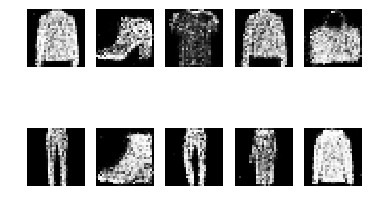

25100 [D loss: 0.652087, acc.: 58.20%] [G loss: 0.956820]
25200 [D loss: 0.631953, acc.: 62.89%] [G loss: 0.984810]
25300 [D loss: 0.644178, acc.: 63.67%] [G loss: 0.920785]
25400 [D loss: 0.647567, acc.: 64.84%] [G loss: 0.907136]
25500 [D loss: 0.649749, acc.: 61.72%] [G loss: 0.975359]
25600 [D loss: 0.629084, acc.: 64.84%] [G loss: 1.001115]
25700 [D loss: 0.616343, acc.: 69.14%] [G loss: 0.931252]
25800 [D loss: 0.607165, acc.: 70.31%] [G loss: 0.925309]
25900 [D loss: 0.653386, acc.: 61.72%] [G loss: 0.976006]
26000 [D loss: 0.640018, acc.: 62.50%] [G loss: 0.922892]
26100 [D loss: 0.629461, acc.: 67.97%] [G loss: 0.955341]
26200 [D loss: 0.627136, acc.: 66.02%] [G loss: 0.991854]
26300 [D loss: 0.634256, acc.: 65.23%] [G loss: 0.944042]
26400 [D loss: 0.619317, acc.: 69.14%] [G loss: 0.976184]
26500 [D loss: 0.696765, acc.: 54.30%] [G loss: 0.942508]
26600 [D loss: 0.648387, acc.: 61.33%] [G loss: 0.965312]
26700 [D loss: 0.644304, acc.: 60.94%] [G loss: 0.958095]
26800 [D loss:

In [208]:
train(epochs=30000, batch_size=128, sample_interval=5000, latent_dim=latent_dim, generator=generator, discriminator=discriminator, combined=combined)

In [209]:
discriminator_json = discriminator.to_json()
with open("models/discriminator.json", "w") as json_file:
    json_file.write(discriminator_json)
# serialize weights to HDF5
discriminator.save_weights("models/discriminator_model.h5")

generator_json = generator.to_json()
with open("models/generator.json", "w") as json_file:
    json_file.write(generator_json)
# serialize weights to HDF5
generator.save_weights("models/generator_model.h5")

# Sampel generations

In [210]:
def PrintSample():
    r, c = 1, 5
    size = 20

    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5


    fig, axs = plt.subplots(r, c,figsize=(r*size,c*size))
    cnt = 0
    for i in range(r):
        for j in range(c):

            axs[j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[j].axis('off')
            cnt += 1
    #fig.savefig("images/%d.png" % epoch)
    plt.show()
    plt.close()

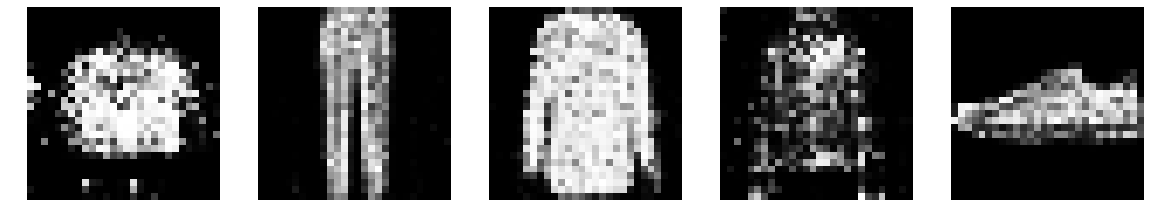

In [211]:
PrintSample()

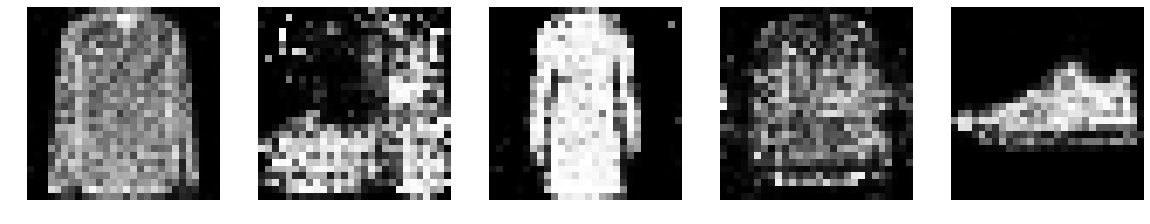

In [212]:
PrintSample()

# Training Conditional GAN

In [213]:
z = Input(shape=(latent_dim,))
label = Input(shape=(1,))

img = generator_CGAN([z,label])
discriminator_CGAN.trainable = False
validity = discriminator_CGAN([img,label])

combined_CGAN = Model([z,label], validity)
combined_CGAN.compile(loss='binary_crossentropy', optimizer=optimizer)

0 [D loss: 0.726925, acc.: 11.72%] [G loss: 0.600252]


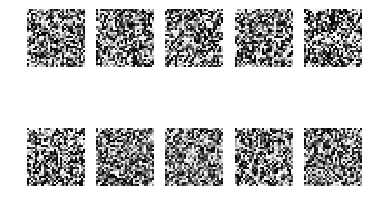

100 [D loss: 0.440410, acc.: 76.56%] [G loss: 2.313755]
200 [D loss: 0.600321, acc.: 73.44%] [G loss: 1.656030]
300 [D loss: 0.715065, acc.: 54.69%] [G loss: 1.104547]
400 [D loss: 0.680153, acc.: 52.34%] [G loss: 0.909528]
500 [D loss: 0.685056, acc.: 48.44%] [G loss: 0.822757]
600 [D loss: 0.700476, acc.: 44.53%] [G loss: 0.808215]
700 [D loss: 0.690991, acc.: 50.00%] [G loss: 0.816037]
800 [D loss: 0.676192, acc.: 57.03%] [G loss: 0.818046]
900 [D loss: 0.693607, acc.: 51.56%] [G loss: 0.725169]
1000 [D loss: 0.697756, acc.: 49.22%] [G loss: 0.776297]
1100 [D loss: 0.680944, acc.: 59.38%] [G loss: 0.736678]
1200 [D loss: 0.681828, acc.: 48.44%] [G loss: 0.741924]
1300 [D loss: 0.693406, acc.: 48.44%] [G loss: 0.734540]
1400 [D loss: 0.692100, acc.: 44.53%] [G loss: 0.747337]
1500 [D loss: 0.692813, acc.: 46.09%] [G loss: 0.733002]
1600 [D loss: 0.705351, acc.: 55.47%] [G loss: 0.744168]
1700 [D loss: 0.685004, acc.: 53.12%] [G loss: 0.744307]
1800 [D loss: 0.717213, acc.: 37.50%] [G

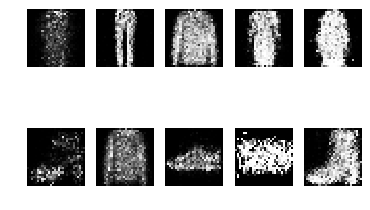

5100 [D loss: 0.694843, acc.: 45.31%] [G loss: 0.704733]
5200 [D loss: 0.699482, acc.: 48.44%] [G loss: 0.706372]
5300 [D loss: 0.696065, acc.: 46.09%] [G loss: 0.701010]
5400 [D loss: 0.692414, acc.: 50.00%] [G loss: 0.695510]
5500 [D loss: 0.689242, acc.: 50.78%] [G loss: 0.705145]
5600 [D loss: 0.697229, acc.: 43.75%] [G loss: 0.705358]
5700 [D loss: 0.690414, acc.: 50.00%] [G loss: 0.707460]
5800 [D loss: 0.696761, acc.: 51.56%] [G loss: 0.704446]
5900 [D loss: 0.695096, acc.: 45.31%] [G loss: 0.693502]
6000 [D loss: 0.695692, acc.: 46.09%] [G loss: 0.705583]
6100 [D loss: 0.689168, acc.: 47.66%] [G loss: 0.697982]
6200 [D loss: 0.691344, acc.: 45.31%] [G loss: 0.703598]
6300 [D loss: 0.697269, acc.: 39.84%] [G loss: 0.703206]
6400 [D loss: 0.689699, acc.: 50.00%] [G loss: 0.705390]
6500 [D loss: 0.691096, acc.: 57.03%] [G loss: 0.706565]
6600 [D loss: 0.689753, acc.: 53.91%] [G loss: 0.708291]
6700 [D loss: 0.693271, acc.: 45.31%] [G loss: 0.700148]
6800 [D loss: 0.690563, acc.: 5

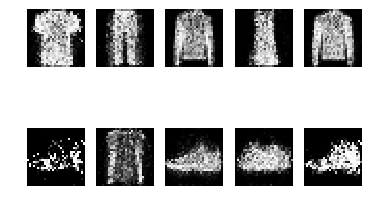

10100 [D loss: 0.693393, acc.: 55.47%] [G loss: 0.693335]
10200 [D loss: 0.688538, acc.: 42.97%] [G loss: 0.707878]
10300 [D loss: 0.692978, acc.: 41.41%] [G loss: 0.699825]
10400 [D loss: 0.691165, acc.: 54.69%] [G loss: 0.700314]
10500 [D loss: 0.696939, acc.: 42.97%] [G loss: 0.694569]
10600 [D loss: 0.698899, acc.: 42.97%] [G loss: 0.700153]
10700 [D loss: 0.693289, acc.: 47.66%] [G loss: 0.701649]
10800 [D loss: 0.694366, acc.: 51.56%] [G loss: 0.694623]
10900 [D loss: 0.694180, acc.: 45.31%] [G loss: 0.703638]
11000 [D loss: 0.693569, acc.: 47.66%] [G loss: 0.700452]
11100 [D loss: 0.694896, acc.: 51.56%] [G loss: 0.696460]
11200 [D loss: 0.690912, acc.: 57.81%] [G loss: 0.697885]
11300 [D loss: 0.690475, acc.: 53.12%] [G loss: 0.696266]
11400 [D loss: 0.693174, acc.: 46.09%] [G loss: 0.700253]
11500 [D loss: 0.694387, acc.: 44.53%] [G loss: 0.700335]
11600 [D loss: 0.695607, acc.: 50.00%] [G loss: 0.709533]
11700 [D loss: 0.695639, acc.: 39.84%] [G loss: 0.697601]
11800 [D loss:

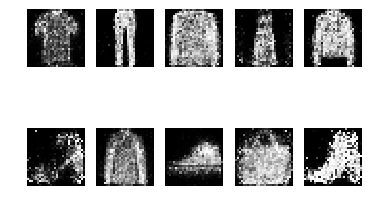

15100 [D loss: 0.692424, acc.: 48.44%] [G loss: 0.693780]
15200 [D loss: 0.687119, acc.: 57.03%] [G loss: 0.691863]
15300 [D loss: 0.695922, acc.: 47.66%] [G loss: 0.692271]
15400 [D loss: 0.695097, acc.: 49.22%] [G loss: 0.694452]
15500 [D loss: 0.691790, acc.: 50.00%] [G loss: 0.705263]
15600 [D loss: 0.690754, acc.: 55.47%] [G loss: 0.693934]
15700 [D loss: 0.694718, acc.: 43.75%] [G loss: 0.699705]
15800 [D loss: 0.694997, acc.: 50.78%] [G loss: 0.697463]
15900 [D loss: 0.691643, acc.: 53.12%] [G loss: 0.697731]
16000 [D loss: 0.697117, acc.: 49.22%] [G loss: 0.703856]
16100 [D loss: 0.691207, acc.: 49.22%] [G loss: 0.699741]
16200 [D loss: 0.692791, acc.: 47.66%] [G loss: 0.692183]
16300 [D loss: 0.695315, acc.: 42.97%] [G loss: 0.696210]
16400 [D loss: 0.693013, acc.: 47.66%] [G loss: 0.693485]
16500 [D loss: 0.691537, acc.: 53.12%] [G loss: 0.701111]
16600 [D loss: 0.692991, acc.: 50.78%] [G loss: 0.702181]
16700 [D loss: 0.694244, acc.: 50.78%] [G loss: 0.697952]
16800 [D loss:

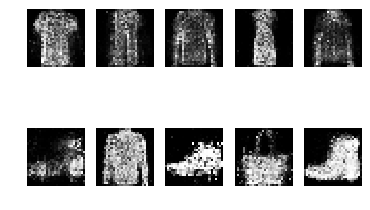

20100 [D loss: 0.692915, acc.: 44.53%] [G loss: 0.698199]
20200 [D loss: 0.689204, acc.: 57.03%] [G loss: 0.702409]
20300 [D loss: 0.692778, acc.: 48.44%] [G loss: 0.705529]
20400 [D loss: 0.688848, acc.: 48.44%] [G loss: 0.696335]
20500 [D loss: 0.690967, acc.: 55.47%] [G loss: 0.701557]
20600 [D loss: 0.690249, acc.: 55.47%] [G loss: 0.707731]
20700 [D loss: 0.694602, acc.: 54.69%] [G loss: 0.702193]
20800 [D loss: 0.691019, acc.: 51.56%] [G loss: 0.702279]
20900 [D loss: 0.695331, acc.: 50.00%] [G loss: 0.705574]
21000 [D loss: 0.688709, acc.: 60.94%] [G loss: 0.698142]
21100 [D loss: 0.694366, acc.: 46.09%] [G loss: 0.695700]
21200 [D loss: 0.692715, acc.: 53.91%] [G loss: 0.700056]
21300 [D loss: 0.697257, acc.: 44.53%] [G loss: 0.696197]
21400 [D loss: 0.691520, acc.: 48.44%] [G loss: 0.696306]
21500 [D loss: 0.694827, acc.: 50.00%] [G loss: 0.698414]
21600 [D loss: 0.689333, acc.: 56.25%] [G loss: 0.705886]
21700 [D loss: 0.695147, acc.: 47.66%] [G loss: 0.701685]
21800 [D loss:

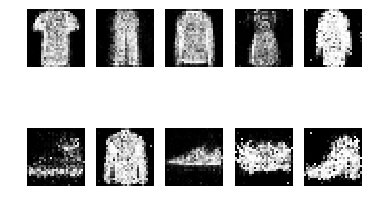

25100 [D loss: 0.691474, acc.: 51.56%] [G loss: 0.705977]
25200 [D loss: 0.690670, acc.: 53.12%] [G loss: 0.690584]
25300 [D loss: 0.687990, acc.: 50.78%] [G loss: 0.715826]
25400 [D loss: 0.691612, acc.: 48.44%] [G loss: 0.711871]
25500 [D loss: 0.688659, acc.: 51.56%] [G loss: 0.701980]
25600 [D loss: 0.690519, acc.: 53.12%] [G loss: 0.694582]
25700 [D loss: 0.685703, acc.: 59.38%] [G loss: 0.712833]
25800 [D loss: 0.688574, acc.: 54.69%] [G loss: 0.696297]
25900 [D loss: 0.696582, acc.: 46.09%] [G loss: 0.708352]
26000 [D loss: 0.691882, acc.: 53.91%] [G loss: 0.707263]
26100 [D loss: 0.693694, acc.: 48.44%] [G loss: 0.696902]
26200 [D loss: 0.696458, acc.: 42.97%] [G loss: 0.691418]
26300 [D loss: 0.693289, acc.: 50.78%] [G loss: 0.707584]
26400 [D loss: 0.683337, acc.: 61.72%] [G loss: 0.699959]
26500 [D loss: 0.689451, acc.: 58.59%] [G loss: 0.705901]
26600 [D loss: 0.694432, acc.: 43.75%] [G loss: 0.706868]
26700 [D loss: 0.691112, acc.: 51.56%] [G loss: 0.701229]
26800 [D loss:

In [214]:
train(epochs=30000, batch_size=64, sample_interval=5000, latent_dim=latent_dim, generator=generator_CGAN, discriminator=discriminator_CGAN, combined=combined_CGAN, GAN = 'CGAN')

In [215]:
discriminator_CGAN_json = discriminator_CGAN.to_json()
with open("models/discriminator_CGAN.json", "w") as json_file:
    json_file.write(discriminator_CGAN_json)
# serialize weights to HDF5
discriminator_CGAN.save_weights("models/discriminator_CGAN_model.h5")

generator_CGAN_json = generator_CGAN.to_json()
with open("models/generator_CGAN.json", "w") as json_file:
    json_file.write(generator_CGAN_json)
# serialize weights to HDF5
generator_CGAN.save_weights("models/generator_CGAN_model.h5")

# Sampled Generations using Conditional Gan

In [216]:
def PrintSamplesCGAN():
    r, c = 1, 5
    size = 20

    noise = np.random.normal(0, 1, (r * c, latent_dim))
    sampled_labels = np.random.randint(10, size=5).reshape(-1, 1)

    gen_imgs = generator_CGAN.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5


    fig, axs = plt.subplots(r, c,figsize=(r*size,c*size))
    cnt = 0
    for i in range(r):
        for j in range(c):

            axs[j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[j].set_title("Class: %s" % class_map[sampled_labels[cnt][0]])
            axs[j].axis('off')
            cnt += 1
    #fig.savefig("images/%d.png" % epoch)
    plt.show()
    plt.close()

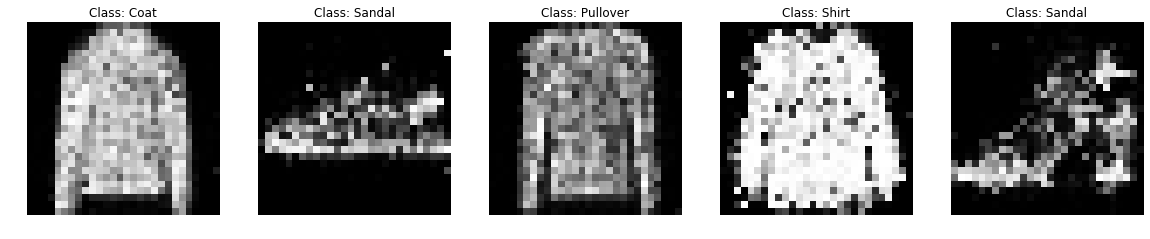

In [217]:
PrintSamplesCGAN()

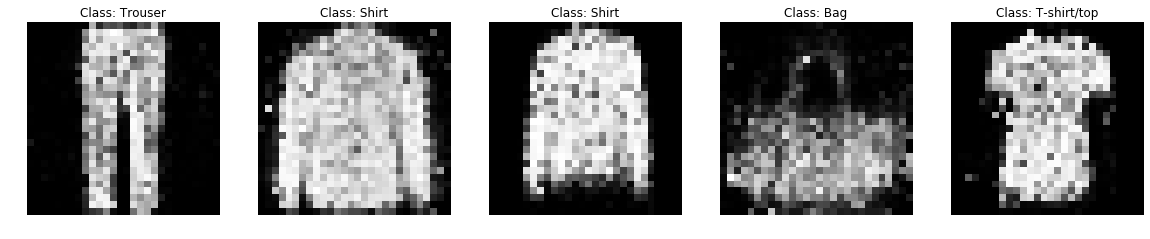

In [233]:
PrintSamplesCGAN()